In [1]:
import tensorflow as tf
import numpy as np
import os
import math
import re
import shutil
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core.dropout import Dropout
from keras.layers.core.flatten import Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ROOT="/content/drive/MyDrive/Dataset_BUSI_with_GT"

In [3]:
def mkfol(p):
  if not os.path.exists("./"+p):
    os.mkdir("./"+p)
    for dir in os.listdir(ROOT):
      os.mkdir(os.path.join("./"+p,dir))
      l=[]
      for i in os.listdir(os.path.join(ROOT,dir)):
        if not re.fullmatch(".*mask.*",i):
          l.append(i)
      for img in l:
        o = os.path.join(ROOT,dir,img)
        d = os.path.join("./"+p,dir)
        shutil.copy(o,d)
  else:
    print(f"{p} already exists.")

In [4]:
mkfol("Sample")

In [5]:
import pandas as pd
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow as tf
from keras.models import *
from tensorflow.keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
import pandas as pd
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow as tf
from keras.models import *
from tensorflow.keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D

from keras import backend as keras
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD

In [6]:
print(len(os.listdir("/content/Sample/malignant")))

210


In [7]:
image_resize = 224

In [8]:
T_ROOT="/content/Sample"
n={}
for dir in os.listdir(ROOT):
  n[dir]=len(os.listdir(os.path.join(ROOT,dir)))
print(n)

{'malignant': 421, 'normal': 266, 'benign': 901}


In [9]:
def mkfol(p,r):
  if not os.path.exists("./"+p):
    os.mkdir("./"+p)
    for dir in os.listdir(T_ROOT):
      os.mkdir(os.path.join("./"+p,dir))
      l=[]
      for i in os.listdir(os.path.join(T_ROOT,dir)):
        l.append(i)
      for img in np.random.choice(a=l,size=math.floor(r*len(l))-2,replace=False):
        o = os.path.join(ROOT,dir,img)
        d = os.path.join("./"+p,dir)
        shutil.copy(o,d)
  else:
    print(f"{p} already exists.")

In [10]:
mkfol("train",0.7)
mkfol("test",0.15)
mkfol("val",0.15)

In [11]:
from keras_preprocessing.image import image_data_generator
def ppi(p):
  i = ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1/255,horizontal_flip=True)
  I = i.flow_from_directory(directory=p,target_size=(224,224),color_mode='rgb',batch_size=16)
  return I
def ppi2(p):
  i = ImageDataGenerator(rescale=1/255)
  I = i.flow_from_directory(directory=p,target_size=(224,224),color_mode='rgb',batch_size=16)
  return I

In [12]:
train_images=ppi("./train")
test_images=ppi2("./test")
val_images=ppi2("./val")

Found 543 images belonging to 3 classes.
Found 110 images belonging to 3 classes.
Found 110 images belonging to 3 classes.


In [13]:
train_images.class_indices

{'benign': 0, 'malignant': 1, 'normal': 2}

In [14]:
def ib(X,f,filters):
  F1,F2,F3 = filters
  X_s = X
  X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Add()([X,X_s])
  X = Activation('relu')(X)
  return X

In [15]:
def cb(X,f,filters,s=2):
  F1,F2,F3 = filters
  X_s = X
  X = Conv2D(F1, (1,1), strides = (s,s))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X)
  X_s = Conv2D(filters = F3 , kernel_size = (1,1), strides = (s,s), padding = 'valid')(X_s)
  X_s = BatchNormalization(axis = 3)(X_s)
  X = Add()([X,X_s])
  X = Activation('relu')(X)
  return X

In [16]:
def Resnet(input_shape=(224,224,3),classes=3):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3,3))(X_input)
    X = Conv2D(64,(7,7),strides=(2,2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)
    X = cb(X, f=3, filters=[64,64,256], s=1)
    X = ib(X, 3, [64,64,256])
    X = ib(X, 3, [64,64,256])
    X = cb(X, f=3, filters = [128,128,512], s=2)
    X = ib(X, 3, [128,128,512])
    X = ib(X, 3, [128,128,512])
    X = ib(X, 3, [128,128,512])
    X = cb(X, f=3, filters = [256,256,1024], s=2)
    X = ib(X, 3, [256,256,1024])
    X = ib(X, 3, [256,256,1024])
    X = ib(X, 3, [256,256,1024])
    X = ib(X, 3, [256,256,1024])
    X = ib(X, 3, [256,256,1024])
    X = cb(X, f=3, filters= [512,512,2048], s=2)
    X = ib(X, 3, [512,512,2048])
    X = ib(X, 3, [512,512,2048])
    X = AveragePooling2D((2,2), name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes),kernel_initializer = glorot_uniform(seed=0))(X)
    return Model(inputs= X_input, outputs = X, name = 'Resnet')

In [17]:
model = Resnet()
model.summary()

Model: "Resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                             

In [18]:
model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [20]:
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=3,verbose=1,mode='auto')
mc = ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5",save_best_only=True,verbose=1,mode='auto')
cd=[es,mc]

In [21]:
#history = model.fit(train_images,batch_size=16,epochs=10, verbose = 1,validation_data=val_images)
history = model.fit_generator(generator=train_images,epochs=10, verbose = 1,validation_data=val_images,callbacks=cd)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.8652 - accuracy: 0.5967
Epoch 1: val_accuracy improved from -inf to 0.55455, saving model to ./bestmodel.h5
34/34 [==============================] - 18s 515ms/step - loss: 0.8652 - accuracy: 0.5967 - val_loss: 0.9660 - val_accuracy: 0.5545
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.8703 - accuracy: 0.6464
Epoch 2: val_accuracy did not improve from 0.55455
34/34 [==============================] - 16s 472ms/step - loss: 0.8703 - accuracy: 0.6464 - val_loss: 0.9579 - val_accuracy: 0.5182
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.8083 - accuracy: 0.6630
Epoch 3: val_accuracy improved from 0.55455 to 0.73636, saving model to ./bestmodel.h5
34/34 [==============================] - 18s 516ms/step - loss: 0.8083 - accuracy: 0.6630 - val_loss: 0.7202 - val_accuracy: 0.7364
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.7577 - accuracy: 0.6483
Epoch 

In [22]:
from keras.models import load_model
model=load_model("/content/bestmodel.h5")

In [23]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import sequential
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'shape' parameter of imshow() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'shape', they should be pass as keyword, not positionally.
  after removing the cwd from sys.path.


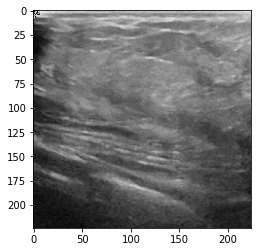

benign


array([[0.51784563, 0.09832389, 0.38383052]], dtype=float32)

In [34]:
path="/content/Sample/benign/benign (108).png"
img=load_img(path,color_mode = "rgb",target_size=(224,224))
input_array=img_to_array(img)/255
plt.imshow(input_array,shape=(512,512,1))
plt.show()
input_array=np.expand_dims(input_array,axis=0)
pred=model.predict(input_array)
npred=np.argmax(pred,axis=1)[0]
x=train_images.class_indices
for a in x.keys():
  if(x[a]==npred):
    print(a)
pred